In [38]:
import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.font_manager as fm

# Register Sarabun font for Thai text rendering
_sarabun_path = "/System/Library/AssetsV2/com_apple_MobileAsset_Font7/bff515501313f56409358f8994642696000d2dbc.asset/AssetData/Sarabun.ttc"
fm.fontManager.addfont(_sarabun_path)
_sarabun_name = fm.FontProperties(fname=_sarabun_path).get_name()

plt.rcParams["font.family"] = _sarabun_name
plt.rcParams["axes.unicode_minus"] = False
plt.rcParams["figure.figsize"] = (14, 6)
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.alpha"] = 0.3

DATA_DIR = Path("../data/smiley159")

In [39]:
# ── Load reference data ──────────────────────────────────────────────
common = json.loads((DATA_DIR / "common-data.json").read_text("utf-8"))
parties_raw = json.loads((DATA_DIR / "party-data.json").read_text("utf-8"))["parties"]
candidates_raw = json.loads((DATA_DIR / "candidate-data.json").read_text("utf-8"))["candidates"]
summary_raw = json.loads((DATA_DIR / "summary.json").read_text("utf-8"))

# Area / province / region lookup tables
area_df = pd.DataFrame(common["areas"])[["code", "provinceCode", "number", "name", "win66PartyCode"]].rename(
    columns={"code": "areaCode", "number": "areaNo", "name": "areaName"}
)
province_df = pd.DataFrame(common["provinces"])[["code", "regionCode", "name"]].rename(
    columns={"code": "provinceCode", "name": "provinceName"}
)
region_df = pd.DataFrame(common["regions"])[["code", "name"]].rename(
    columns={"code": "regionCode", "name": "regionName"}
)
area_meta = (
    area_df
    .merge(province_df, on="provinceCode", how="left")
    .merge(region_df, on="regionCode", how="left")
)

# Party lookup
party_df = pd.DataFrame(parties_raw)[["code", "number", "name", "colorPrimary"]].rename(
    columns={"code": "partyCode", "number": "partyNo", "name": "partyName", "colorPrimary": "partyColor"}
)

print(f"Areas: {len(area_meta)}, Provinces: {province_df.shape[0]}, Regions: {region_df.shape[0]}, Parties: {len(party_df)}")
area_meta.head()

Areas: 400, Provinces: 77, Regions: 6, Parties: 60


,areaCode,provinceCode,areaNo,areaName,win66PartyCode,regionCode,provinceName,regionName
0,AREA-8101,PROVINCE-81,1,กระบี่ เขต 1,PARTY-0037,south,กระบี่,ใต้
1,AREA-8102,PROVINCE-81,2,กระบี่ เขต 2,PARTY-0037,south,กระบี่,ใต้
2,AREA-8103,PROVINCE-81,3,กระบี่ เขต 3,PARTY-0037,south,กระบี่,ใต้
3,AREA-1001,PROVINCE-10,1,กรุงเทพมหานคร เขต 1,PARTY-0046,bangkok,กรุงเทพมหานคร,กรุงเทพฯ
4,AREA-1010,PROVINCE-10,10,กรุงเทพมหานคร เขต 10,PARTY-0046,bangkok,กรุงเทพมหานคร,กรุงเทพฯ


In [40]:
# ── Flatten constituency results into one row per (area, candidate) ──
const_raw = json.loads((DATA_DIR / "all-areas-constituency-results.json").read_text("utf-8"))

rows = []
for area in const_raw["areas"]:
    base = {
        "areaCode": area["areaCode"],
        "goodVotes": area["goodVotes"],
        "badVotes": area["badVotes"],
        "noVotes": area["noVotes"],
        "totalVotes": area["totalVotes"],
        "totalEligibleVoters": area.get("totalEligibleVoters", 0),
        "voteProgressPercent": area.get("voteProgressPercent", 0),
    }
    for e in area["entries"]:
        rows.append({**base, **e})

const_df = (
    pd.DataFrame(rows)
    .merge(party_df, on="partyCode", how="left")
    .merge(area_meta, on="areaCode", how="left")
)

# ── Flatten party-list results into one row per (area, party) ────────
pl_raw = json.loads((DATA_DIR / "all-areas-party-list-results.json").read_text("utf-8"))

rows = []
for area in pl_raw["areas"]:
    base = {
        "areaCode": area["areaCode"],
        "goodVotes_pl": area["goodVotes"],
        "badVotes_pl": area["badVotes"],
        "noVotes_pl": area["noVotes"],
        "totalVotes_pl": area["totalVotes"],
        "voteProgressPercent_pl": area.get("voteProgressPercent", 0),
    }
    for e in area["entries"]:
        rows.append({**base, **e})

pl_df = (
    pd.DataFrame(rows)
    .rename(columns={"voteTotal": "voteTotal_pl", "votePercent": "votePercent_pl", "rank": "rank_pl"})
    .merge(party_df, on="partyCode", how="left")
    .merge(area_meta, on="areaCode", how="left")
)

print(f"Constituency rows: {len(const_df):,}  |  Party-list rows: {len(pl_df):,}")
const_df.head()

Constituency rows: 3,527  |  Party-list rows: 24,000


,areaCode,goodVotes,badVotes,noVotes,totalVotes,totalEligibleVoters,voteProgressPercent,candidateCode,partyCode,rank,...,partyNo,partyName,partyColor,provinceCode,areaNo,areaName,win66PartyCode,regionCode,provinceName,regionName
0,AREA-1001,79789,1083,4012,84884,130423,95,CANDIDATE-MP-100105,PARTY-0046,1,...,46,ประชาชน,#FF6D21,PROVINCE-10,1,กรุงเทพมหานคร เขต 1,PARTY-0046,bangkok,กรุงเทพมหานคร,กรุงเทพฯ
1,AREA-1001,79789,1083,4012,84884,130423,95,CANDIDATE-MP-100109,PARTY-0027,2,...,27,ประชาธิปัตย์,#15A5F5,PROVINCE-10,1,กรุงเทพมหานคร เขต 1,PARTY-0046,bangkok,กรุงเทพมหานคร,กรุงเทพฯ
2,AREA-1001,79789,1083,4012,84884,130423,95,CANDIDATE-MP-100101,PARTY-0037,3,...,37,ภูมิใจไทย,#312682,PROVINCE-10,1,กรุงเทพมหานคร เขต 1,PARTY-0046,bangkok,กรุงเทพมหานคร,กรุงเทพฯ
3,AREA-1001,79789,1083,4012,84884,130423,95,CANDIDATE-MP-100108,PARTY-0009,4,...,9,เพื่อไทย,#F11824,PROVINCE-10,1,กรุงเทพมหานคร เขต 1,PARTY-0046,bangkok,กรุงเทพมหานคร,กรุงเทพฯ
4,AREA-1001,79789,1083,4012,84884,130423,95,CANDIDATE-MP-100106,PARTY-0006,5,...,6,รวมไทยสร้างชาติ,#1742B9,PROVINCE-10,1,กรุงเทพมหานคร เขต 1,PARTY-0046,bangkok,กรุงเทพมหานคร,กรุงเทพฯ


In [41]:
# ── Area-level summary (one row per area) ────────────────────────────
area_summary = (
    const_df
    .drop_duplicates("areaCode")
    [["areaCode", "areaName", "areaNo", "provinceName", "regionName",
      "goodVotes", "badVotes", "noVotes", "totalVotes", "totalEligibleVoters",
      "voteProgressPercent"]]
    .copy()
)
area_summary["turnout"] = area_summary["totalVotes"] / area_summary["totalEligibleVoters"]
area_summary["badVoteRate"] = area_summary["badVotes"] / area_summary["totalVotes"]
area_summary["noVoteRate"] = area_summary["noVotes"] / area_summary["totalVotes"]

# Winner per area (rank == 1)
winners = const_df[const_df["rank"] == 1][["areaCode", "partyCode", "partyName", "partyColor", "voteTotal", "votePercent"]].rename(
    columns={"voteTotal": "winnerVotes", "votePercent": "winnerPct", "partyName": "winnerParty", "partyColor": "winnerColor"}
)
area_summary = area_summary.merge(winners, on="areaCode", how="left")

# Runner-up
runners = const_df[const_df["rank"] == 2][["areaCode", "voteTotal", "partyName"]].rename(
    columns={"voteTotal": "runnerUpVotes", "partyName": "runnerUpParty"}
)
area_summary = area_summary.merge(runners, on="areaCode", how="left")
area_summary["winMargin"] = (area_summary["winnerVotes"] - area_summary["runnerUpVotes"]) / area_summary["goodVotes"]

print(f"Area summary: {len(area_summary)} areas")
area_summary.describe()

Area summary: 400 areas


,areaNo,goodVotes,badVotes,noVotes,totalVotes,totalEligibleVoters,voteProgressPercent,turnout,badVoteRate,noVoteRate,winnerVotes,winnerPct,runnerUpVotes,winMargin
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.0,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,4.887500,83894.187500,3071.707500,3592.772500,90558.667500,132307.307500,95.0,0.684313,0.034213,0.039343,40734.450000,48.714975,22990.155000,0.213954
std,5.247254,14130.742501,1226.817762,1837.219127,14941.469653,10981.254561,0.0,0.094198,0.013177,0.018662,10399.488193,10.288411,7482.663373,0.153354
min,1.000000,13835.000000,514.000000,522.000000,14912.000000,89158.000000,95.0,0.115203,0.010191,0.006616,7812.000000,27.800000,3678.000000,0.001438
25%,2.000000,75886.750000,2231.000000,2193.750000,81474.750000,126600.000000,95.0,0.634733,0.025235,0.025708,33741.750000,41.305000,17301.000000,0.091011
50%,3.000000,83412.000000,2857.000000,3494.000000,90143.500000,132524.500000,95.0,0.684625,0.032957,0.038609,39648.000000,46.815000,22711.000000,0.179585
75%,6.000000,90538.500000,3719.500000,4716.000000,97764.250000,139208.500000,95.0,0.733675,0.041612,0.050915,46964.250000,54.580000,27856.250000,0.302227
max,33.000000,196707.000000,9247.000000,17504.000000,207598.000000,176920.000000,95.0,1.444060,0.102548,0.198627,98736.000000,80.740000,64284.000000,0.716039


## Hypothesis: Vote-buying "number spillover"

Voters get 2 papers — **constituency** (candidate number only) and **party list** (party number + name). Candidate numbers are random per area, but party-list numbers are fixed nationally.

**If vote-buying happens**, voters are told "vote number X" for the constituency candidate. Confused voters write the same number X on the party-list paper too — accidentally boosting whichever small party happens to have national number X.

**Test**: For each area's winning constituency candidate (number N), check if party-list party #N got **excess votes** compared to its national average.

In [42]:
# ── Build candidate number lookup ────────────────────────────────────
cand_df = pd.DataFrame(candidates_raw)[["code", "areaCode", "partyCode", "number"]].rename(
    columns={"code": "candidateCode", "number": "candidateNo"}
)

# ── Add candidateNo to constituency results ─────────────────────────
const_with_no = const_df.merge(
    cand_df[["candidateCode", "candidateNo"]],
    on="candidateCode",
    how="left",
)

# ── Party-list: party number → partyCode mapping ────────────────────
partyno_to_code = party_df.set_index("partyNo")["partyCode"].to_dict()
partyno_to_name = party_df.set_index("partyNo")["partyName"].to_dict()

# ── Party-list national average vote share per party ─────────────────
pl_national = (
    pl_df
    .groupby("partyCode")
    .agg(totalVotes_pl=("voteTotal_pl", "sum"), nAreas=("areaCode", "nunique"))
    .reset_index()
)
total_pl_votes = pl_df.drop_duplicates("areaCode")["goodVotes_pl"].sum()
pl_national["nationalPct"] = pl_national["totalVotes_pl"] / total_pl_votes * 100

print(f"Total party-list good votes nationally: {total_pl_votes:,.0f}")
pl_national.sort_values("nationalPct", ascending=False).head(10)

Total party-list good votes nationally: 31,838,525


,partyCode,totalVotes_pl,nAreas,nationalPct
45,PARTY-0046,9747116,400,30.614220
36,PARTY-0037,5941805,400,18.662312
8,PARTY-0009,5134599,400,16.127000
26,PARTY-0027,3635139,400,11.417423
10,PARTY-0011,1042928,400,3.275679
5,PARTY-0006,703381,400,2.209214
1,PARTY-0002,627376,400,1.970493
41,PARTY-0042,605405,400,1.901486
4,PARTY-0005,402183,400,1.263196
32,PARTY-0033,401397,400,1.260727


In [43]:
# ── Core analysis: For each area's top candidates, find same-numbered party-list party ──
# Focus on top-3 candidates per area (most likely to be vote-bought)
top_cands = const_with_no[const_with_no["rank"] <= 3].copy()

# Map candidateNo → the party-list party with that same number
top_cands["pl_partyCode_sameNo"] = top_cands["candidateNo"].map(partyno_to_code)
top_cands["pl_partyName_sameNo"] = top_cands["candidateNo"].map(partyno_to_name)

# Get the actual party-list vote for that same-numbered party in this area
pl_lookup = pl_df[["areaCode", "partyCode", "voteTotal_pl", "votePercent_pl", "goodVotes_pl"]].rename(
    columns={"partyCode": "pl_partyCode_sameNo",
             "voteTotal_pl": "pl_sameNo_votes",
             "votePercent_pl": "pl_sameNo_pct"}
)

top_cands = top_cands.merge(pl_lookup, on=["areaCode", "pl_partyCode_sameNo"], how="left")

# Add the national average for this same-numbered party
pl_nat_lookup = pl_national[["partyCode", "nationalPct"]].rename(
    columns={"partyCode": "pl_partyCode_sameNo", "nationalPct": "pl_sameNo_nationalPct"}
)
top_cands = top_cands.merge(pl_nat_lookup, on="pl_partyCode_sameNo", how="left")

# Compute excess: how much more this party-list party got in this area vs national avg
top_cands["pl_excess_pct"] = top_cands["pl_sameNo_pct"] - top_cands["pl_sameNo_nationalPct"]
top_cands["pl_excess_votes"] = top_cands["pl_sameNo_votes"] - (top_cands["pl_sameNo_nationalPct"] / 100 * top_cands["goodVotes_pl"])

# Flag: is the same-numbered party a "small" party? (national share < 2%)
top_cands["pl_sameNo_isSmall"] = top_cands["pl_sameNo_nationalPct"] < 2

print(f"Rows with valid same-number mapping: {top_cands['pl_sameNo_votes'].notna().sum()}")
print(f"Of which map to a small party: {(top_cands['pl_sameNo_isSmall'] & top_cands['pl_sameNo_votes'].notna()).sum()}")

# Show most suspicious cases: winner's number maps to small party, big excess
suspicious = (
    top_cands[
        (top_cands["rank"] == 1) &
        (top_cands["pl_sameNo_isSmall"]) &
        (top_cands["pl_excess_pct"] > 0)
    ]
    .sort_values("pl_excess_pct", ascending=False)
    [["areaCode", "areaName", "provinceName", "regionName",
      "partyName", "candidateNo", "voteTotal", "votePercent",
      "pl_partyName_sameNo", "pl_sameNo_pct", "pl_sameNo_nationalPct",
      "pl_excess_pct", "pl_excess_votes"]]
)
print(f"\nSuspicious areas (winner maps to small party with positive excess): {len(suspicious)}")
suspicious.head(20)

Rows with valid same-number mapping: 1200
Of which map to a small party: 1061

Suspicious areas (winner maps to small party with positive excess): 299


,areaCode,areaName,provinceName,regionName,partyName,candidateNo,voteTotal,votePercent,pl_partyName_sameNo,pl_sameNo_pct,pl_sameNo_nationalPct,pl_excess_pct,pl_excess_votes
837,AREA-6004,นครสวรรค์ เขต 4,นครสวรรค์,เหนือ,ภูมิใจไทย,2,55552,66.71,เพื่อชาติไทย,8.18,1.970493,6.209507,4523.081832
489,AREA-3601,ชัยภูมิ เขต 1,ชัยภูมิ,อีสาน,เพื่อไทย,2,7812,56.47,เพื่อชาติไทย,8.01,1.970493,6.039507,844.446218
834,AREA-6003,นครสวรรค์ เขต 3,นครสวรรค์,เหนือ,กล้าธรรม,5,52056,58.52,รวมใจไทย,6.70,1.263196,5.436804,4387.613395
300,AREA-2503,ปราจีนบุรี เขต 3,ปราจีนบุรี,ตะวันออก,ภูมิใจไทย,2,44256,53.66,เพื่อชาติไทย,7.24,1.970493,5.269507,4086.591828
495,AREA-3603,ชัยภูมิ เขต 3,ชัยภูมิ,อีสาน,ภูมิใจไทย,1,44269,63.29,ไทยทรัพย์ทวี,6.09,0.892284,5.197716,3558.044361
951,AREA-7104,กาญจนบุรี เขต 4,กาญจนบุรี,กลาง,ภูมิใจไทย,1,51379,63.23,ไทยทรัพย์ทวี,6.04,0.892284,5.147716,3971.942118
852,AREA-6201,กำแพงเพชร เขต 1,กำแพงเพชร,เหนือ,กล้าธรรม,2,44898,52.31,เพื่อชาติไทย,6.87,1.970493,4.899507,3974.412659
933,AREA-7003,ราชบุรี เขต 3,ราชบุรี,กลาง,กล้าธรรม,2,49859,53.95,เพื่อชาติไทย,6.77,1.970493,4.799507,4458.278747
222,AREA-1904,สระบุรี เขต 4,สระบุรี,กลาง,กล้าธรรม,5,47308,53.43,รวมใจไทย,6.05,1.263196,4.786804,4030.769934
600,AREA-4202,เลย เขต 2,เลย,อีสาน,เพื่อไทย,2,27345,38.44,เพื่อชาติไทย,6.53,1.970493,4.559507,3065.670867


### Statistical test: Do same-numbered party-list parties get more votes?

Compare two groups across all areas:
- **Treatment**: the party-list party whose number matches the winning constituency candidate's number
- **Control**: all other small party-list parties in the same area

If vote-buying spillover exists, the treatment group should have significantly higher vote shares than the control.

In [44]:
from scipy import stats

# Identify small parties (national party-list share < 2%)
small_party_codes = set(pl_national[pl_national["nationalPct"] < 2]["partyCode"])

# For each area, get the winner's candidateNo
winners_no = (
    const_with_no[const_with_no["rank"] == 1]
    [["areaCode", "candidateNo", "partyCode", "voteTotal"]]
    .rename(columns={"partyCode": "winnerPartyCode", "voteTotal": "winnerVotes"})
)

# Get all party-list results for small parties, per area
pl_small = pl_df[pl_df["partyCode"].isin(small_party_codes)][
    ["areaCode", "partyCode", "partyNo", "voteTotal_pl", "votePercent_pl", "goodVotes_pl"]
].copy()

# Merge to know the winner's candidateNo in each area
pl_small = pl_small.merge(winners_no[["areaCode", "candidateNo"]], on="areaCode", how="left")

# Flag: does this small party's number match the winner's candidate number?
pl_small["isMatchedNumber"] = pl_small["partyNo"] == pl_small["candidateNo"]

treatment = pl_small[pl_small["isMatchedNumber"]]["votePercent_pl"].dropna()
control = pl_small[~pl_small["isMatchedNumber"]]["votePercent_pl"].dropna()

print(f"Treatment (matched number): n={len(treatment)}, mean={treatment.mean():.4f}%, median={treatment.median():.4f}%")
print(f"Control (unmatched):        n={len(control)}, mean={control.mean():.4f}%, median={control.median():.4f}%")
print(f"Ratio of means: {treatment.mean() / control.mean():.2f}x")
print()

# Mann-Whitney U test (non-parametric, doesn't assume normality)
u_stat, p_val = stats.mannwhitneyu(treatment, control, alternative="greater")
print(f"Mann-Whitney U test (treatment > control): U={u_stat:,.0f}, p={p_val:.2e}")

# Also Welch's t-test
t_stat, p_val_t = stats.ttest_ind(treatment, control, equal_var=False, alternative="greater")
print(f"Welch's t-test (treatment > control): t={t_stat:.2f}, p={p_val_t:.2e}")

Treatment (matched number): n=360, mean=2.7156%, median=2.6800%
Control (unmatched):        n=21240, mean=0.2919%, median=0.1000%
Ratio of means: 9.30x

Mann-Whitney U test (treatment > control): U=7,326,846, p=1.54e-196
Welch's t-test (treatment > control): t=26.95, p=3.08e-89


In [45]:
# ── Extend to top-3 candidates (not just winner) ─────────────────────
# Voters may also remember the numbers of runner-up candidates being promoted
top3_no = (
    const_with_no[const_with_no["rank"] <= 3]
    [["areaCode", "candidateNo", "rank", "voteTotal", "votePercent"]]
)

pl_small2 = pl_df[pl_df["partyCode"].isin(small_party_codes)][
    ["areaCode", "partyCode", "partyNo", "voteTotal_pl", "votePercent_pl", "goodVotes_pl"]
].copy()

# Cross-join: for each area, check if any of the top-3 candidate numbers match
pl_small2 = pl_small2.merge(top3_no, on="areaCode", how="left")
pl_small2["isMatchedNumber"] = pl_small2["partyNo"] == pl_small2["candidateNo"]

# For each (area, small-party), flag if ANY top-3 candidate matches its number
matched_any = (
    pl_small2[pl_small2["isMatchedNumber"]]
    .groupby(["areaCode", "partyCode"])
    .agg(
        matched_rank=("rank", "min"),  # best-ranked matching candidate
        matched_constVotes=("voteTotal", "max"),
        matched_constPct=("votePercent", "max"),
    )
    .reset_index()
)

pl_area_party = (
    pl_small2
    .drop_duplicates(["areaCode", "partyCode"])
    [["areaCode", "partyCode", "partyNo", "voteTotal_pl", "votePercent_pl", "goodVotes_pl"]]
)
pl_area_party = pl_area_party.merge(matched_any, on=["areaCode", "partyCode"], how="left")
pl_area_party["isMatched"] = pl_area_party["matched_rank"].notna()

treat2 = pl_area_party[pl_area_party["isMatched"]]["votePercent_pl"].dropna()
ctrl2 = pl_area_party[~pl_area_party["isMatched"]]["votePercent_pl"].dropna()

print("Extended test (matching ANY top-3 candidate number):")
print(f"  Treatment: n={len(treat2)}, mean={treat2.mean():.4f}%, median={treat2.median():.4f}%")
print(f"  Control:   n={len(ctrl2)}, mean={ctrl2.mean():.4f}%, median={ctrl2.median():.4f}%")
print(f"  Ratio of means: {treat2.mean() / ctrl2.mean():.2f}x")
u2, p2 = stats.mannwhitneyu(treat2, ctrl2, alternative="greater")
print(f"  Mann-Whitney p={p2:.2e}")

Extended test (matching ANY top-3 candidate number):
  Treatment: n=1061, mean=1.7952%, median=1.3700%
  Control:   n=20539, mean=0.2568%, median=0.0900%
  Ratio of means: 6.99x
  Mann-Whitney p=0.00e+00


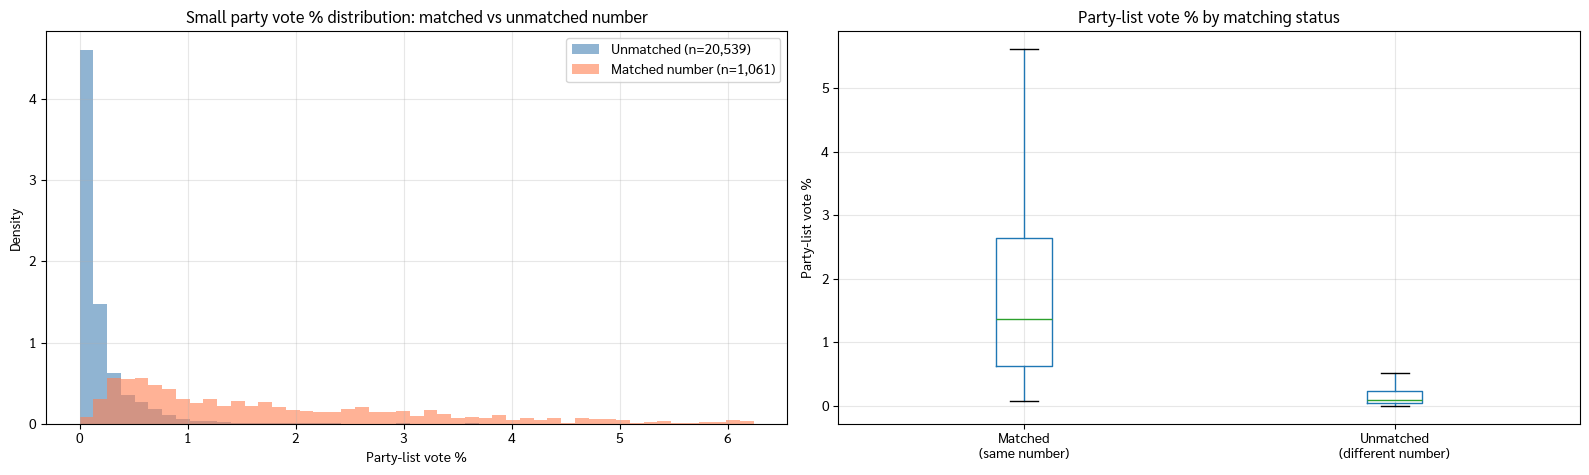

In [46]:
# ── Visualization 1: Distribution of party-list vote % (matched vs unmatched) ──
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Histogram
bins = np.linspace(0, max(treat2.quantile(0.99), ctrl2.quantile(0.99)), 50)
axes[0].hist(ctrl2, bins=bins, alpha=0.6, label=f"Unmatched (n={len(ctrl2):,})", density=True, color="steelblue")
axes[0].hist(treat2, bins=bins, alpha=0.6, label=f"Matched number (n={len(treat2):,})", density=True, color="coral")
axes[0].set_xlabel("Party-list vote %")
axes[0].set_ylabel("Density")
axes[0].set_title("Small party vote % distribution: matched vs unmatched number")
axes[0].legend()

# Box plot
data_box = pd.DataFrame({
    "vote_pct": pd.concat([treat2, ctrl2]),
    "group": ["Matched\n(same number)"] * len(treat2) + ["Unmatched\n(different number)"] * len(ctrl2)
})
data_box.boxplot(column="vote_pct", by="group", ax=axes[1], showfliers=False)
axes[1].set_title("Party-list vote % by matching status")
axes[1].set_ylabel("Party-list vote %")
axes[1].set_xlabel("")
fig.suptitle("")

plt.tight_layout()
plt.show()

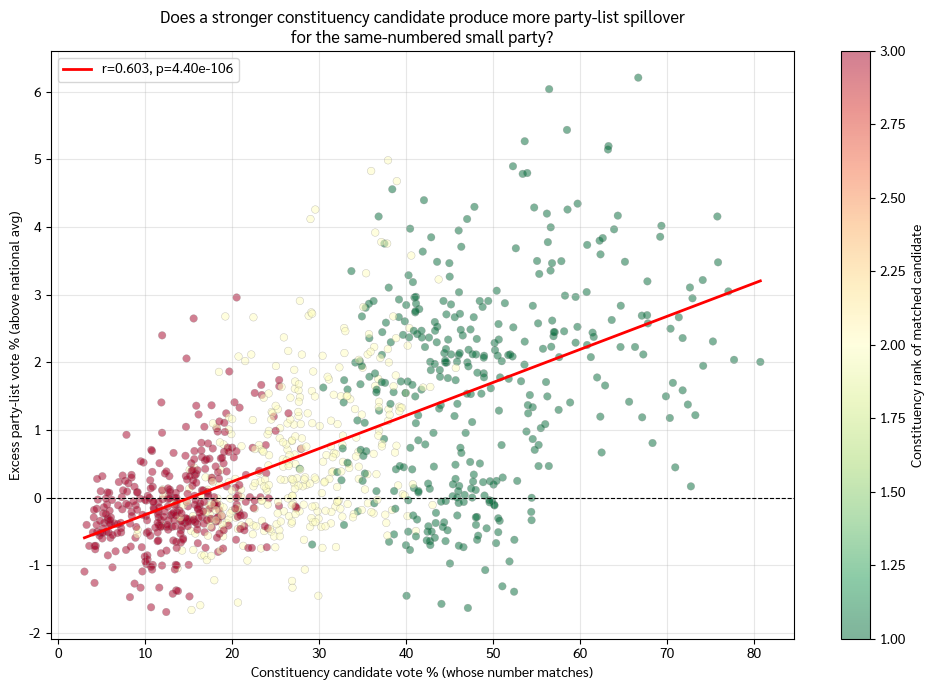

In [47]:
# ── Visualization 2: Scatter — constituency candidate votes vs same-numbered party-list votes ──
# For matched pairs only, does a stronger constituency candidate produce more party-list spillover?
matched_pairs = pl_area_party[pl_area_party["isMatched"]].copy()
matched_pairs = matched_pairs.merge(
    pl_national[["partyCode", "nationalPct"]],
    on="partyCode", how="left"
)
matched_pairs["excess_pct"] = matched_pairs["votePercent_pl"] - matched_pairs["nationalPct"]

fig, ax = plt.subplots(figsize=(10, 7))
sc = ax.scatter(
    matched_pairs["matched_constPct"],
    matched_pairs["excess_pct"],
    c=matched_pairs["matched_rank"],
    cmap="RdYlGn_r",
    alpha=0.5,
    s=30,
    edgecolors="gray",
    linewidths=0.3,
)
ax.axhline(0, color="black", linewidth=0.8, linestyle="--")
ax.set_xlabel("Constituency candidate vote % (whose number matches)")
ax.set_ylabel("Excess party-list vote % (above national avg)")
ax.set_title("Does a stronger constituency candidate produce more party-list spillover\nfor the same-numbered small party?")
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label("Constituency rank of matched candidate")

# Regression line
mask = matched_pairs[["matched_constPct", "excess_pct"]].dropna()
slope, intercept, r, p, se = stats.linregress(mask["matched_constPct"], mask["excess_pct"])
x_line = np.linspace(mask["matched_constPct"].min(), mask["matched_constPct"].max(), 100)
ax.plot(x_line, slope * x_line + intercept, "r-", linewidth=2,
        label=f"r={r:.3f}, p={p:.2e}")
ax.legend()

plt.tight_layout()
plt.show()

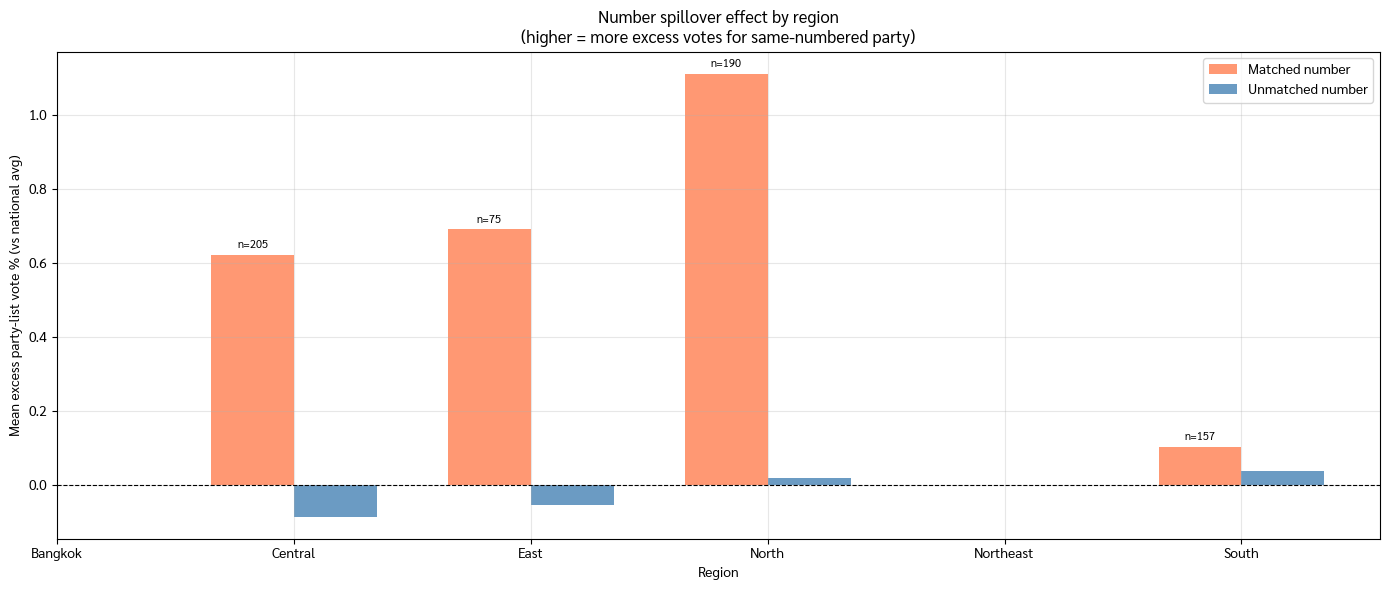

In [48]:
# ── Visualization 3: Breakdown by region ─────────────────────────────
# Vote-buying is more common in rural areas — does the effect vary by region?
matched_with_region = pl_area_party[pl_area_party["isMatched"]].merge(
    area_meta[["areaCode", "regionName"]], on="areaCode", how="left"
)
matched_with_region = matched_with_region.merge(
    pl_national[["partyCode", "nationalPct"]], on="partyCode", how="left"
)
matched_with_region["excess_pct"] = matched_with_region["votePercent_pl"] - matched_with_region["nationalPct"]

unmatched_with_region = pl_area_party[~pl_area_party["isMatched"]].merge(
    area_meta[["areaCode", "regionName"]], on="areaCode", how="left"
)
unmatched_with_region = unmatched_with_region.merge(
    pl_national[["partyCode", "nationalPct"]], on="partyCode", how="left"
)
unmatched_with_region["excess_pct"] = unmatched_with_region["votePercent_pl"] - unmatched_with_region["nationalPct"]

region_order = ["กรุงเทพมหานคร", "กลาง", "ตะวันออก", "เหนือ", "ตะวันออกเฉียงเหนือ", "ใต้"]
region_labels = ["Bangkok", "Central", "East", "North", "Northeast", "South"]

fig, ax = plt.subplots(figsize=(14, 6))
x = np.arange(len(region_order))
width = 0.35

matched_means = [matched_with_region[matched_with_region["regionName"] == r]["excess_pct"].mean() for r in region_order]
unmatched_means = [unmatched_with_region[unmatched_with_region["regionName"] == r]["excess_pct"].mean() for r in region_order]

bars1 = ax.bar(x - width/2, matched_means, width, label="Matched number", color="coral", alpha=0.8)
bars2 = ax.bar(x + width/2, unmatched_means, width, label="Unmatched number", color="steelblue", alpha=0.8)

ax.set_xlabel("Region")
ax.set_ylabel("Mean excess party-list vote % (vs national avg)")
ax.set_title("Number spillover effect by region\n(higher = more excess votes for same-numbered party)")
ax.set_xticks(x)
ax.set_xticklabels(region_labels)
ax.axhline(0, color="black", linewidth=0.8, linestyle="--")
ax.legend()

# Add count labels
for i, r in enumerate(region_order):
    n = len(matched_with_region[matched_with_region["regionName"] == r])
    ax.text(x[i] - width/2, matched_means[i] + 0.01, f"n={n}", ha="center", va="bottom", fontsize=8)

plt.tight_layout()
plt.show()

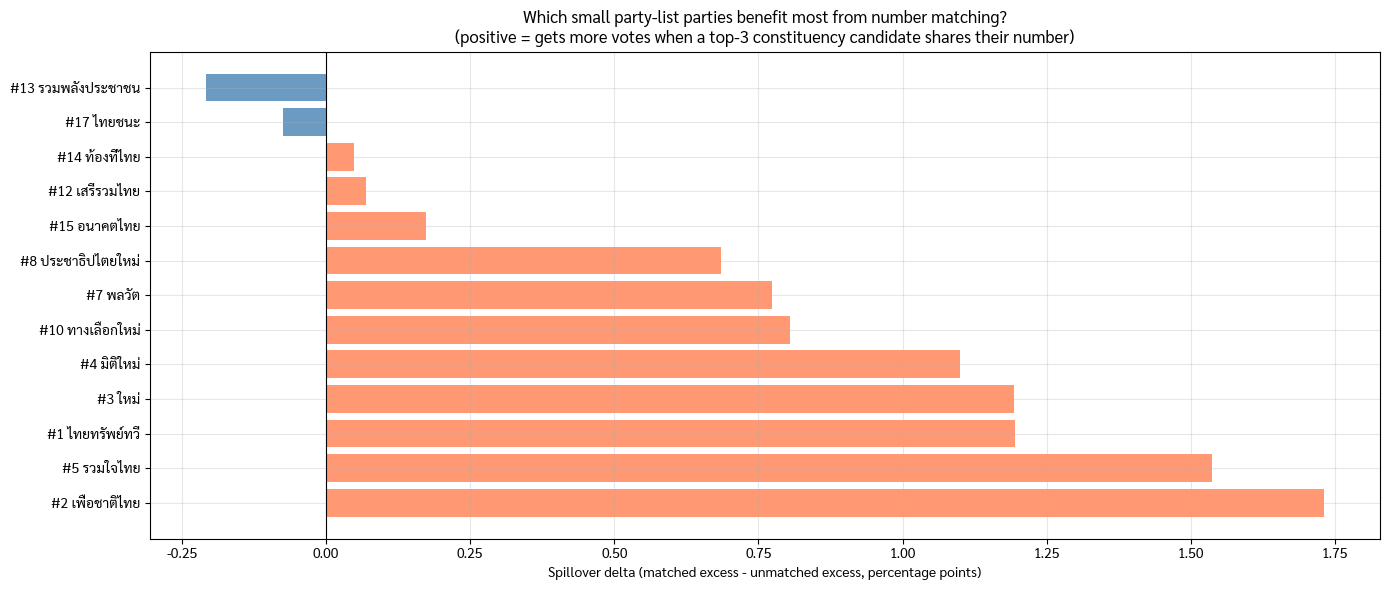

,partyNo,partyName,n_matched,excess_matched,excess_unmatched,spillover_delta
0,2,เพื่อชาติไทย,188.0,0.996,-0.735,1.731
1,5,รวมใจไทย,177.0,0.877,-0.660,1.537
2,1,ไทยทรัพย์ทวี,187.0,0.658,-0.538,1.196
3,3,ใหม่,184.0,0.649,-0.545,1.194
4,4,มิติใหม่,175.0,0.629,-0.470,1.099
5,10,ทางเลือกใหม่,8.0,0.785,-0.019,0.805
6,7,พลวัต,80.0,0.620,-0.154,0.774
7,8,ประชาธิปไตยใหม่,44.0,0.607,-0.078,0.685
8,15,อนาคตไทย,5.0,0.173,-0.001,0.174
9,12,เสรีรวมไทย,4.0,0.072,0.002,0.070


In [49]:
# ── Visualization 4: Per-party-number breakdown ──────────────────────
# Which small party numbers benefit most from spillover?
# This shows: for party-list party #N, how much more do they get in areas where
# a top-3 constituency candidate also has number N?

party_effect = (
    pl_area_party
    .merge(pl_national[["partyCode", "nationalPct"]], on="partyCode", how="left")
    .assign(excess_pct=lambda d: d["votePercent_pl"] - d["nationalPct"])
)

effect_by_party = (
    party_effect
    .groupby(["partyNo", "isMatched"])
    .agg(mean_excess=("excess_pct", "mean"), n=("excess_pct", "count"))
    .reset_index()
    .pivot(index="partyNo", columns="isMatched", values=["mean_excess", "n"])
)
effect_by_party.columns = ["excess_unmatched", "excess_matched", "n_unmatched", "n_matched"]
effect_by_party["spillover_delta"] = effect_by_party["excess_matched"] - effect_by_party["excess_unmatched"]
effect_by_party = effect_by_party.dropna().sort_values("spillover_delta", ascending=False)

# Add party names
effect_by_party = effect_by_party.reset_index().merge(
    party_df[["partyNo", "partyName"]], on="partyNo", how="left"
)

fig, ax = plt.subplots(figsize=(14, 6))
colors = ["coral" if x > 0 else "steelblue" for x in effect_by_party["spillover_delta"]]
bars = ax.barh(
    [f"#{row.partyNo} {row.partyName}" for _, row in effect_by_party.iterrows()],
    effect_by_party["spillover_delta"],
    color=colors,
    alpha=0.8,
)
ax.set_xlabel("Spillover delta (matched excess - unmatched excess, percentage points)")
ax.set_title("Which small party-list parties benefit most from number matching?\n(positive = gets more votes when a top-3 constituency candidate shares their number)")
ax.axvline(0, color="black", linewidth=0.8)

plt.tight_layout()
plt.show()

effect_by_party[["partyNo", "partyName", "n_matched", "excess_matched", "excess_unmatched", "spillover_delta"]].round(3)

### Dose-response: Does the effect scale with constituency vote strength?

If the hypothesis is real, the spillover should be **stronger** when the matched constituency candidate won by a larger margin (more voters told to "remember the number").

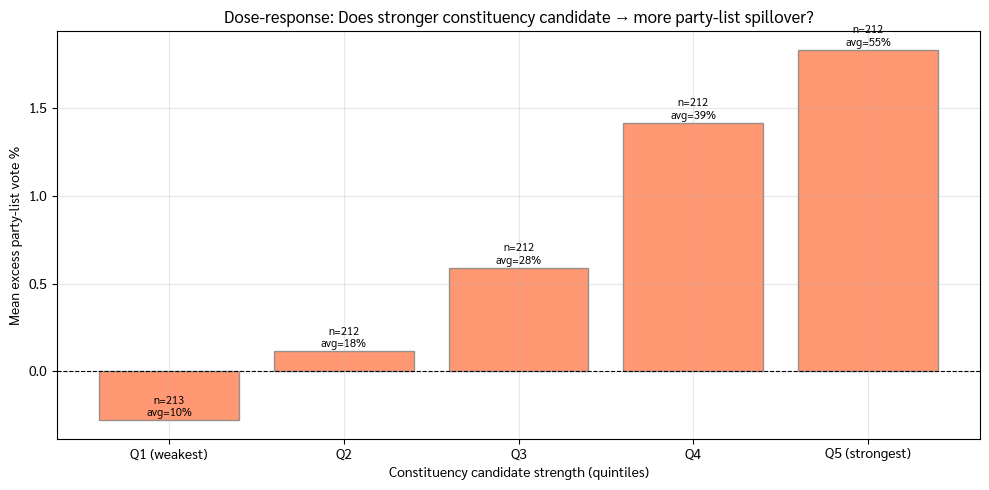

,mean_excess,median_excess,n,mean_const_pct
const_bin,,,,
Q1 (weakest),-0.277373,-0.292284,213,10.052535
Q2,0.114689,-0.071389,212,18.343113
Q3,0.590142,0.448611,212,27.834009
Q4,1.413748,1.546969,212,39.474906
Q5 (strongest),1.829471,2.003155,212,55.322642


In [50]:
# ── Dose-response: bin by constituency candidate strength ────────────
matched_dose = matched_pairs.copy()
matched_dose["const_bin"] = pd.qcut(matched_dose["matched_constPct"], q=5, labels=[
    "Q1 (weakest)", "Q2", "Q3", "Q4", "Q5 (strongest)"
])

dose_stats = (
    matched_dose
    .groupby("const_bin", observed=True)
    .agg(
        mean_excess=("excess_pct", "mean"),
        median_excess=("excess_pct", "median"),
        n=("excess_pct", "count"),
        mean_const_pct=("matched_constPct", "mean"),
    )
)

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(dose_stats.index, dose_stats["mean_excess"], color="coral", alpha=0.8, edgecolor="gray")
ax.set_xlabel("Constituency candidate strength (quintiles)")
ax.set_ylabel("Mean excess party-list vote %")
ax.set_title("Dose-response: Does stronger constituency candidate → more party-list spillover?")
ax.axhline(0, color="black", linewidth=0.8, linestyle="--")

for i, (idx, row) in enumerate(dose_stats.iterrows()):
    ax.text(i, row["mean_excess"] + 0.005, f"n={int(row['n'])}\navg={row['mean_const_pct']:.0f}%",
            ha="center", va="bottom", fontsize=8)

plt.tight_layout()
plt.show()

dose_stats

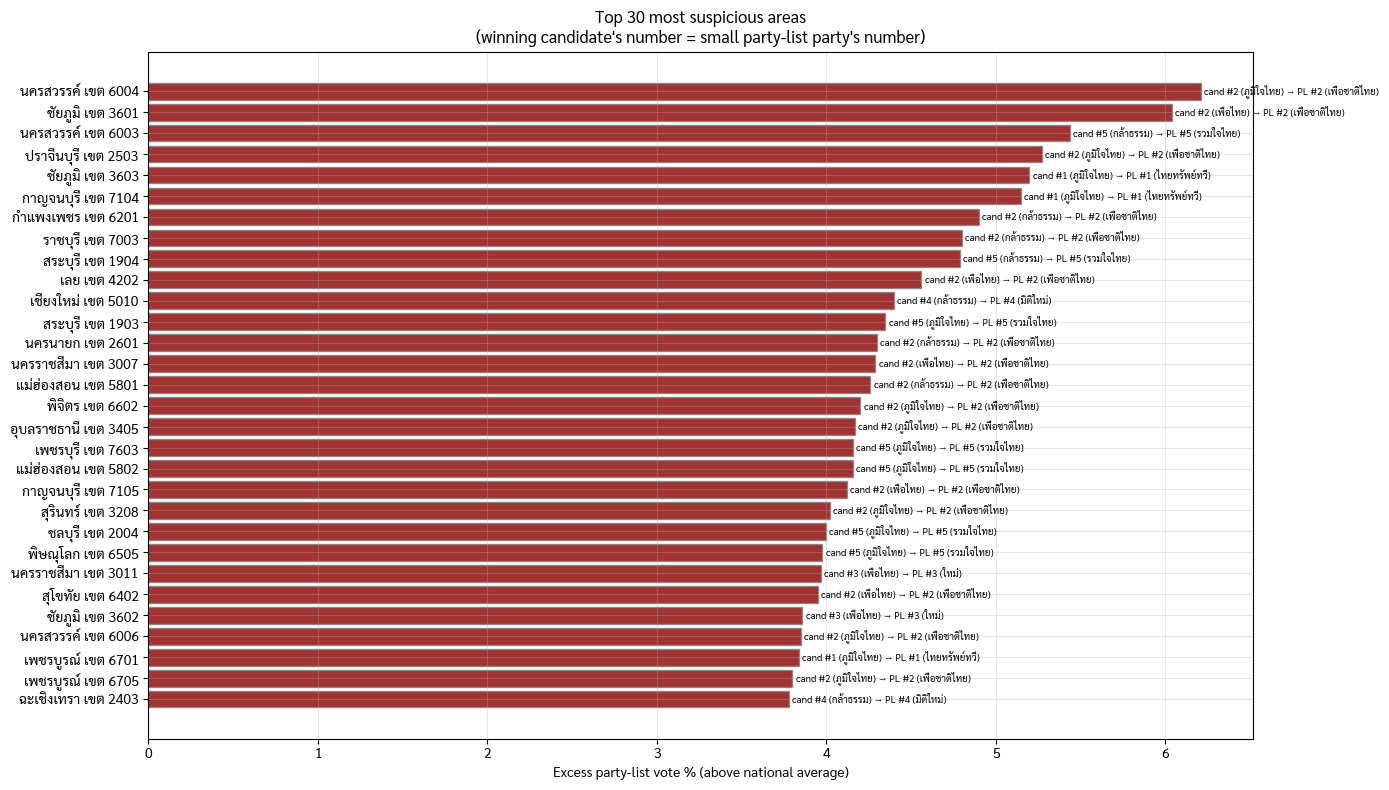

In [51]:
# ── Visualization 5: Top 30 most suspicious areas ────────────────────
# Areas where a winning candidate's number maps to a small party that got huge excess
top_suspicious = suspicious.head(30).copy()
top_suspicious["label"] = (
    top_suspicious["provinceName"] + " เขต " + top_suspicious["areaCode"].str.extract(r"(\d+)$")[0].astype(str)
)

fig, ax = plt.subplots(figsize=(14, 8))
colors_bar = top_suspicious["pl_excess_pct"].apply(lambda x: "darkred" if x > 1 else "coral")
ax.barh(
    top_suspicious["label"][::-1],
    top_suspicious["pl_excess_pct"][::-1],
    color=colors_bar[::-1],
    alpha=0.8,
    edgecolor="gray",
)
ax.set_xlabel("Excess party-list vote % (above national average)")
ax.set_title("Top 30 most suspicious areas\n(winning candidate's number = small party-list party's number)")

# Add annotations
for i, (_, row) in enumerate(top_suspicious[::-1].iterrows()):
    ax.text(
        row["pl_excess_pct"] + 0.02,
        i,
        f"cand #{int(row['candidateNo'])} ({row['partyName']}) → PL #{int(row['candidateNo'])} ({row['pl_partyName_sameNo']})",
        va="center",
        fontsize=7,
    )

plt.tight_layout()
plt.show()

### Suspicious activity by winning party

Which constituency-winning parties have the most areas where their candidate's ballot number caused anomalous spillover to a same-numbered small party-list party?

In [52]:
# ── Suspicious activity summary by winning party ─────────────────────
# `suspicious` df has all areas where rank-1 candidate's number matches a small
# party-list party AND that party got positive excess votes.

# Total seats won per party (for context / normalisation)
total_seats = (
    const_with_no[const_with_no["rank"] == 1]
    .groupby("partyName")
    .size()
    .rename("total_seats_won")
)

# Aggregate suspicious areas by winning party
party_suspicious = (
    suspicious
    .groupby("partyName")
    .agg(
        suspicious_areas=("areaCode", "count"),
        mean_excess_pct=("pl_excess_pct", "mean"),
        median_excess_pct=("pl_excess_pct", "median"),
        max_excess_pct=("pl_excess_pct", "max"),
        total_excess_votes=("pl_excess_votes", "sum"),
        mean_winner_pct=("votePercent", "mean"),
    )
    .join(total_seats)
    .reset_index()
)
party_suspicious["pct_of_seats_suspicious"] = (
    party_suspicious["suspicious_areas"] / party_suspicious["total_seats_won"] * 100
)
party_suspicious = party_suspicious.sort_values("suspicious_areas", ascending=False)

# Also get party colors for the chart
party_suspicious = party_suspicious.merge(
    party_df[["partyName", "partyColor"]].drop_duplicates(), on="partyName", how="left"
)

party_suspicious[
    ["partyName", "suspicious_areas", "total_seats_won", "pct_of_seats_suspicious",
     "mean_excess_pct", "median_excess_pct", "max_excess_pct",
     "total_excess_votes", "mean_winner_pct"]
].round(3)

,partyName,suspicious_areas,total_seats_won,pct_of_seats_suspicious,mean_excess_pct,median_excess_pct,max_excess_pct,total_excess_votes,mean_winner_pct
0,ภูมิใจไทย,159,174,91.379,2.122,2.078,6.210,258802.072,53.070
1,เพื่อไทย,51,58,87.931,2.545,2.367,6.040,94403.329,46.571
2,กล้าธรรม,48,56,85.714,2.484,2.363,5.437,95751.917,45.386
3,ประชาชน,24,87,27.586,0.285,0.195,1.600,5759.643,44.200
4,ไทรวมพลัง,5,5,100.000,2.328,2.407,3.357,8929.788,53.952
5,ประชาชาติ,4,4,100.000,1.516,1.634,2.088,4923.519,45.068
6,ประชาธิปัตย์,3,10,30.000,0.361,0.298,0.687,843.297,44.200
7,พลังประชารัฐ,3,4,75.000,2.441,2.018,3.597,5913.983,44.773
8,โอกาสใหม่,1,1,100.000,3.638,3.638,3.638,2382.227,41.940
9,ไทยสร้างไทย,1,1,100.000,1.028,1.028,1.028,723.390,55.510


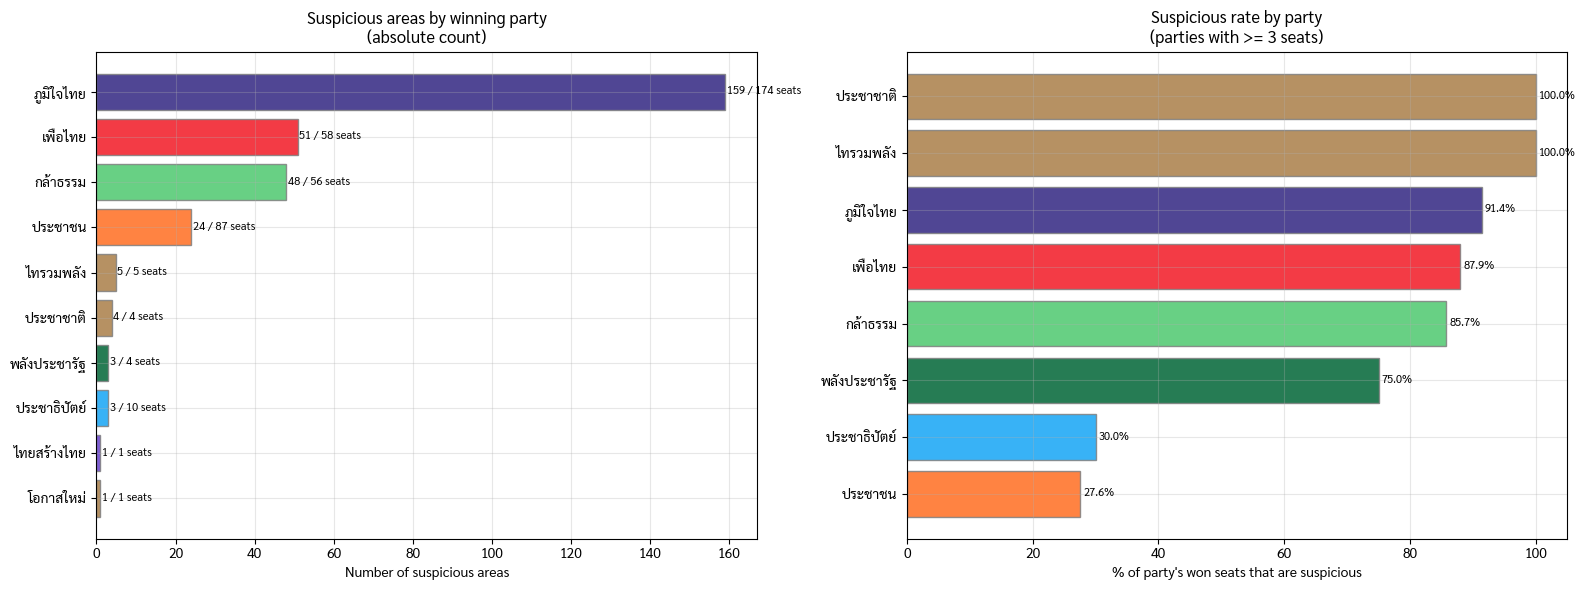

In [53]:
# ── Chart: suspicious areas by party (absolute count + % of seats) ────
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

ps = party_suspicious.sort_values("suspicious_areas", ascending=True)
colors_abs = [c if pd.notna(c) else "#999999" for c in ps["partyColor"]]

# Left: absolute count
axes[0].barh(ps["partyName"], ps["suspicious_areas"], color=colors_abs, alpha=0.85, edgecolor="gray")
axes[0].set_xlabel("Number of suspicious areas")
axes[0].set_title("Suspicious areas by winning party\n(absolute count)")
for i, (_, row) in enumerate(ps.iterrows()):
    axes[0].text(row["suspicious_areas"] + 0.3, i,
                 f'{int(row["suspicious_areas"])} / {int(row["total_seats_won"])} seats',
                 va="center", fontsize=8)

# Right: % of seats that are suspicious
ps2 = party_suspicious[party_suspicious["total_seats_won"] >= 3].sort_values("pct_of_seats_suspicious", ascending=True)
colors_pct = [c if pd.notna(c) else "#999999" for c in ps2["partyColor"]]

axes[1].barh(ps2["partyName"], ps2["pct_of_seats_suspicious"], color=colors_pct, alpha=0.85, edgecolor="gray")
axes[1].set_xlabel("% of party's won seats that are suspicious")
axes[1].set_title("Suspicious rate by party\n(parties with >= 3 seats)")
for i, (_, row) in enumerate(ps2.iterrows()):
    axes[1].text(row["pct_of_seats_suspicious"] + 0.5, i,
                 f'{row["pct_of_seats_suspicious"]:.1f}%',
                 va="center", fontsize=8)

plt.tight_layout()
plt.show()

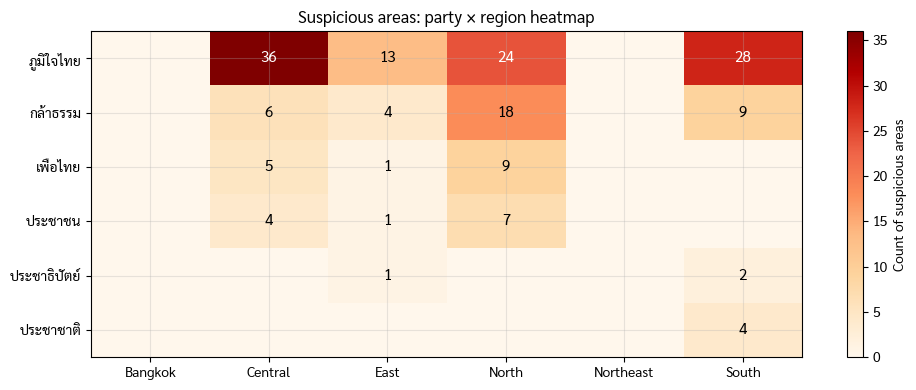

In [54]:
# ── Heatmap: excess votes by party × region ──────────────────────────
# Which parties show the spillover effect in which regions?
# `suspicious` already has regionName from the earlier merge with area_meta.

region_labels_map = dict(zip(
    ["กรุงเทพมหานคร", "กลาง", "ตะวันออก", "เหนือ", "ตะวันออกเฉียงเหนือ", "ใต้"],
    ["Bangkok", "Central", "East", "North", "Northeast", "South"],
))

pivot_count = (
    suspicious
    .groupby(["partyName", "regionName"])
    .size()
    .unstack(fill_value=0)
)
# Reorder columns and rename to English
pivot_count = pivot_count.reindex(columns=region_labels_map.keys(), fill_value=0)
pivot_count.columns = [region_labels_map[c] for c in pivot_count.columns]

# Only show parties with >= 2 suspicious areas
pivot_count = pivot_count[pivot_count.sum(axis=1) >= 2].sort_values(
    pivot_count.columns.tolist(), ascending=False
)

fig, ax = plt.subplots(figsize=(10, max(4, len(pivot_count) * 0.5 + 1)))
im = ax.imshow(pivot_count.values, cmap="OrRd", aspect="auto")

ax.set_xticks(range(len(pivot_count.columns)))
ax.set_xticklabels(pivot_count.columns)
ax.set_yticks(range(len(pivot_count.index)))
ax.set_yticklabels(pivot_count.index)
ax.set_title("Suspicious areas: party × region heatmap")

# Annotate cells with counts
for i in range(len(pivot_count.index)):
    for j in range(len(pivot_count.columns)):
        val = pivot_count.iloc[i, j]
        if val > 0:
            ax.text(j, i, str(val), ha="center", va="center",
                    color="white" if val > pivot_count.values.max() * 0.6 else "black",
                    fontsize=11, fontweight="bold")

plt.colorbar(im, ax=ax, label="Count of suspicious areas")
plt.tight_layout()
plt.show()

### Spillover by every major-party candidate

For **every** constituency candidate from a major party (national party-list share ≥ 2%), not just winners, map their ballot number to the same-numbered small party-list party and show the excess votes. Each dot is one candidate, colored by their party.

Major-party candidates with small-party spillover data: 1,674
Parties: ['ภูมิใจไทย', 'ประชาชน', 'เพื่อไทย', 'ประชาธิปัตย์', 'กล้าธรรม']


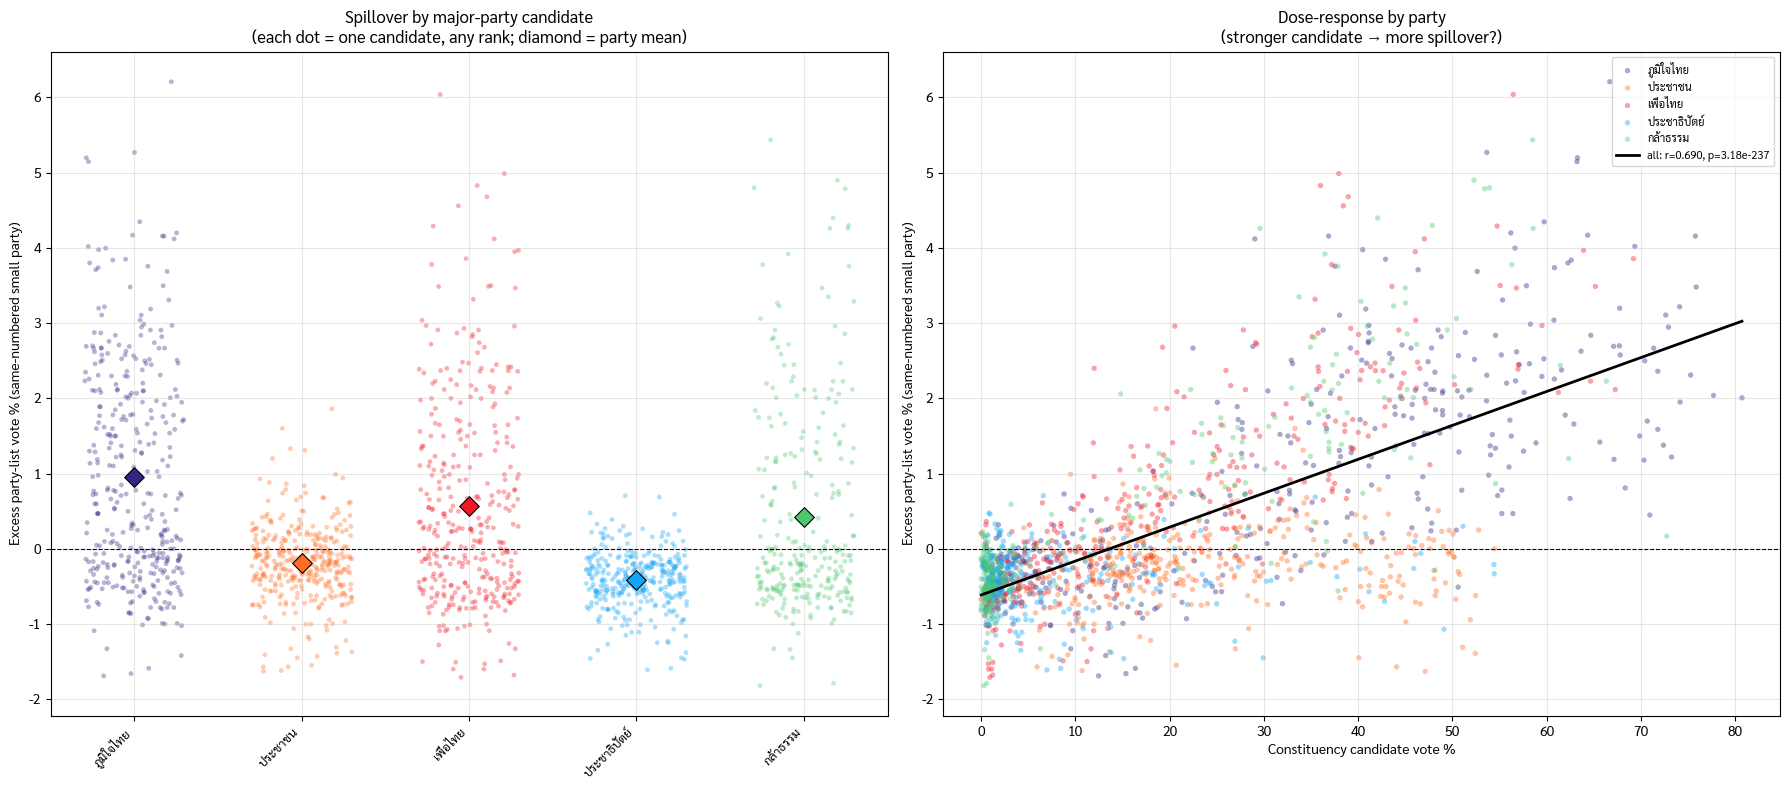

,n_candidates,mean_excess,median_excess,pct_positive,mean_const_pct
partyName,,,,,
ภูมิใจไทย,360,0.958,0.639,64.167,32.090
ประชาชน,350,-0.190,-0.183,30.286,24.928
เพื่อไทย,354,0.566,0.264,57.062,18.353
ประชาธิปัตย์,334,-0.418,-0.403,9.880,6.392
กล้าธรรม,276,0.418,-0.154,42.391,14.509


In [55]:
# ── Every major-party candidate's spillover effect ───────────────────
MAJOR_PARTY_NAMES = ["ภูมิใจไทย", "ประชาชน", "เพื่อไทย", "ประชาธิปัตย์", "กล้าธรรม"]
major_party_codes = set(party_df[party_df["partyName"].isin(MAJOR_PARTY_NAMES)]["partyCode"])

# ALL candidates from these parties (any rank)
all_major = const_with_no[const_with_no["partyCode"].isin(major_party_codes)].copy()

# Map candidateNo → same-numbered party-list party
all_major["pl_partyCode_sameNo"] = all_major["candidateNo"].map(partyno_to_code)
all_major["pl_partyName_sameNo"] = all_major["candidateNo"].map(partyno_to_name)

# Get the actual party-list vote for that same-numbered party in this area
all_major = all_major.merge(pl_lookup, on=["areaCode", "pl_partyCode_sameNo"], how="left")

# Add national average for the same-numbered party
all_major = all_major.merge(pl_nat_lookup, on="pl_partyCode_sameNo", how="left")

# Compute excess
all_major["pl_excess_pct"] = all_major["pl_sameNo_pct"] - all_major["pl_sameNo_nationalPct"]

# Only keep cases where matched party is small (national < 2%) and has data
all_major["pl_sameNo_isSmall"] = all_major["pl_sameNo_nationalPct"] < 2
plot_df = all_major[all_major["pl_sameNo_isSmall"] & all_major["pl_sameNo_pct"].notna()].copy()

# Use the specified party order
party_order = [p for p in MAJOR_PARTY_NAMES if p in plot_df["partyName"].values]
party_color_map = party_df.drop_duplicates("partyName").set_index("partyName")["partyColor"].to_dict()

print(f"Major-party candidates with small-party spillover data: {len(plot_df):,}")
print(f"Parties: {party_order}")

# ── Plot 1: Strip plot — spillover excess by party ───────────────────
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

rng_plot = np.random.default_rng(42)
for i, pname in enumerate(party_order):
    subset = plot_df[plot_df["partyName"] == pname]
    color = party_color_map.get(pname, "#999999")
    jitter = rng_plot.uniform(-0.3, 0.3, len(subset))
    axes[0].scatter(
        np.full(len(subset), i) + jitter,
        subset["pl_excess_pct"],
        c=color, alpha=0.35, s=12, edgecolors="none",
    )
    # Mean marker
    axes[0].scatter(i, subset["pl_excess_pct"].mean(), c=color,
                    s=100, marker="D", edgecolors="black", linewidths=0.8, zorder=5)

axes[0].set_xticks(range(len(party_order)))
axes[0].set_xticklabels(party_order, rotation=45, ha="right", fontsize=9)
axes[0].axhline(0, color="black", linewidth=0.8, linestyle="--")
axes[0].set_ylabel("Excess party-list vote % (same-numbered small party)")
axes[0].set_title("Spillover by major-party candidate\n(each dot = one candidate, any rank; diamond = party mean)")
axes[0].set_xlim(-0.5, len(party_order) - 0.5)

# ── Plot 2: Scatter — constituency vote % vs spillover, colored by party ──
for pname in party_order:
    subset = plot_df[plot_df["partyName"] == pname]
    color = party_color_map.get(pname, "#999999")
    axes[1].scatter(
        subset["votePercent"],
        subset["pl_excess_pct"],
        c=color, alpha=0.4, s=15, edgecolors="none",
        label=pname,
    )

axes[1].axhline(0, color="black", linewidth=0.8, linestyle="--")
axes[1].set_xlabel("Constituency candidate vote %")
axes[1].set_ylabel("Excess party-list vote % (same-numbered small party)")
axes[1].set_title("Dose-response by party\n(stronger candidate → more spillover?)")
axes[1].legend(fontsize=8, loc="upper right", framealpha=0.8)

# Overall regression line
valid = plot_df[["votePercent", "pl_excess_pct"]].dropna()
slope, intercept, r, p, se = stats.linregress(valid["votePercent"], valid["pl_excess_pct"])
x_line = np.linspace(valid["votePercent"].min(), valid["votePercent"].max(), 100)
axes[1].plot(x_line, slope * x_line + intercept, "k-", linewidth=2,
             label=f"all: r={r:.3f}, p={p:.2e}")
axes[1].legend(fontsize=8, loc="upper right", framealpha=0.8)

plt.tight_layout()
plt.show()

# ── Summary table by party ───────────────────────────────────────────
party_stats = (
    plot_df.groupby("partyName")
    .agg(
        n_candidates=("areaCode", "count"),
        mean_excess=("pl_excess_pct", "mean"),
        median_excess=("pl_excess_pct", "median"),
        pct_positive=("pl_excess_pct", lambda x: (x > 0).mean() * 100),
        mean_const_pct=("votePercent", "mean"),
    )
    .reindex(party_order)
    .round(3)
)
party_stats

### Placebo test: Randomized candidate numbers

If the effect is real, it should **disappear** when we randomly shuffle candidate numbers within each area. We run 1000 permutations and compare the real effect size against the null distribution.

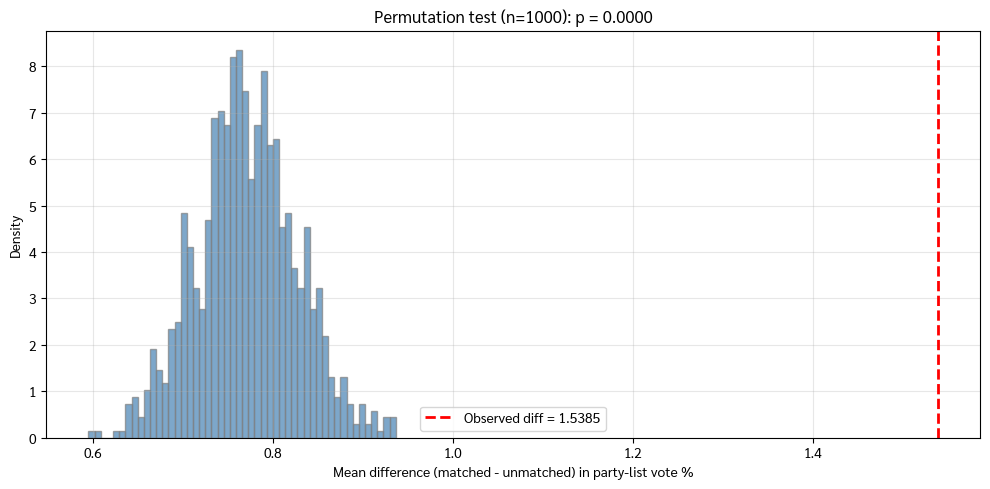

Observed difference: 1.5385 percentage points
Permutation p-value: 0.0000
95th percentile of null: 0.8605


In [56]:
# ── Permutation test ─────────────────────────────────────────────────
rng = np.random.default_rng(42)

# Real effect: mean party-list vote % for matched vs unmatched
real_diff = treat2.mean() - ctrl2.mean()

# Base data: all small-party party-list observations with area's winner candidateNo
base = pl_small.drop_duplicates(["areaCode", "partyCode"]).copy()
base = base[base["votePercent_pl"].notna()].copy()

# For permutation: shuffle candidateNo within each area, then recompute matched/unmatched
n_perms = 1000
perm_diffs = []

# Pre-group for speed
area_groups = base.groupby("areaCode")

for _ in range(n_perms):
    # Shuffle the winner's candidateNo assignment across areas
    shuffled = base.copy()
    # Randomly reassign candidateNo (winner's number) across areas
    area_codes = shuffled["areaCode"].unique()
    cand_nos = shuffled.groupby("areaCode")["candidateNo"].first().values.copy()
    rng.shuffle(cand_nos)
    shuffle_map = dict(zip(area_codes, cand_nos))
    shuffled["candidateNo"] = shuffled["areaCode"].map(shuffle_map)
    shuffled["isMatchedNumber"] = shuffled["partyNo"] == shuffled["candidateNo"]

    treat_perm = shuffled[shuffled["isMatchedNumber"]]["votePercent_pl"]
    ctrl_perm = shuffled[~shuffled["isMatchedNumber"]]["votePercent_pl"]
    if len(treat_perm) > 0 and len(ctrl_perm) > 0:
        perm_diffs.append(treat_perm.mean() - ctrl_perm.mean())

perm_diffs = np.array(perm_diffs)
p_perm = (perm_diffs >= real_diff).mean()

fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(perm_diffs, bins=50, alpha=0.7, color="steelblue", edgecolor="gray", density=True)
ax.axvline(real_diff, color="red", linewidth=2, linestyle="--", label=f"Observed diff = {real_diff:.4f}")
ax.set_xlabel("Mean difference (matched - unmatched) in party-list vote %")
ax.set_ylabel("Density")
ax.set_title(f"Permutation test (n={n_perms}): p = {p_perm:.4f}")
ax.legend()

plt.tight_layout()
plt.show()

print(f"Observed difference: {real_diff:.4f} percentage points")
print(f"Permutation p-value: {p_perm:.4f}")
print(f"95th percentile of null: {np.percentile(perm_diffs, 95):.4f}")

### Summary of findings

| Analysis | What it tests | Key metric |
|----------|-------------|-----------|
| **Treatment vs Control** | Do same-numbered small parties get more votes? | Mean vote % difference |
| **Scatter + regression** | Does stronger constituency candidate → bigger spillover? | Correlation r and p-value |
| **Regional breakdown** | Is the effect stronger in rural regions? | Excess vote % by region |
| **Per-party breakdown** | Which small party numbers benefit most? | Spillover delta |
| **Dose-response** | Does the effect scale with candidate strength? | Monotonic trend in quintiles |
| **Permutation test** | Could the effect be due to chance? | p-value vs shuffled null |
| **Top suspicious areas** | Where is the effect most extreme? | Ranked list of areas |